In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as sps
%matplotlib widget

sys.path.insert(0, '../../drlib')
import drlib as dr

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [14]:
def limCalc(P_lim):
    V_lim = (P_lim * 50)**0.5
    E_lim = 7 * V_lim
    epsilon_lim = E_lim/3.3e3

    print('P lim = ', P_lim, 'W')
    print('V lim = ', V_lim, 'V')
    print('E lim = ', E_lim, 'V/m')
    print('epsilon lim = ', epsilon_lim)
    
class genData:
    '''
    Inputs
    ------------------------
    sigFreqs: array-like
        Frequencies to generate signals. 
        [MHz] 
    sigAmps: array-like
        Amplitudes for signals. 
        Units linear and proportional to voltage, but arbitrary
        Must be same length as sigFreqs 
    mean: float
        mean value for noise
    std: float
        standard deviation of noise
    numSamples: float
        numbers of samples to capture. Twice as long as the fft
    sampleRate: float
        rate samples are captured 
        [MHz]
    numAvg: int
        number of averages to be computed using averaging methods
    
    
    Attributes
    ------------------------
    timeArr: np array
        array of times which signal is sampled by ADC
        [us]
    freqs: np array
        frequencies corosponding to bins of fft
        [MHz]
    
    '''
    def __init__(self,
            sigFreqs, 
            sigAmps,
            mean,
            std, 
            numSamples,
            sampleRate,
            numAvg):
        
        #check for valid args
        if len(sigFreqs) != len(sigAmps):
            raise ValueError('sigFreqs and sigAmps must be same length')
        
        #assign attributes to args
        self.sigFreqs = sigFreqs
        self.sigAmps = sigAmps
        self.mean = mean
        self.std = std
        self.numSamples = numSamples
        self.numAvg = numAvg
        
        #compute additional attributes
        self._halfNumSamples = self.numSamples//2
        self.sampleRate = sampleRate
        self.timeArr = np.asarray([i for i in range(0, self.numSamples)])/self.sampleRate
        self._signals = np.zeros(len(self.timeArr))
        for i in range(len(self.sigFreqs)):
            self._signals += self.sigAmps[i] * np.sin(2*np.pi * self.sigFreqs[i] * self.timeArr)
        self.freqs = np.linspace(0, self.sampleRate//2, self.numSamples//2)[1:]
        self.genTimeData()
        
        '''
        ###Testing 8bit###
        self._signals = np.zeros(len(self.timeArr), dtype = np. int8)
        for i in range(len(self.sigFreqs)):
            self._signals += np.rint(self.sigAmps[i] * np.sin(2*np.pi * self.sigFreqs[i] * self.timeArr))
        '''
        
    def genTimeData(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = np.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeDataGpu(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = np.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(cupy.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeData8Bit(self):
        noiseData = np.asarray(
            np.rint(np.random.normal(mean, std, 2**24)), dtype = np. int8)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)

        
    def computePowAvg(self):
        self.powAvg = self.powSpec
        for i in range(1, self.numAvg):
            #print(i)
            self.genTimeData()
            self.powAvg = self.powAvg * (i-1)/i + self.powSpec/i

    def setNumAvg(self, numAvg):
        self.numAvg = numAvg


################mean################
P lim =  1.5e-19 W
V lim =  2.7386127875258306e-09 V
E lim =  1.9170289512680815e-08 V/m
epsilon lim =  5.809178640206307e-12
################std################
P lim =  1e-22 W
V lim =  7.071067811865475e-11 V
E lim =  4.949747468305833e-10 V/m
epsilon lim =  1.499923475244192e-13


Text(0, 0.5, 'E-field (nV/m)')

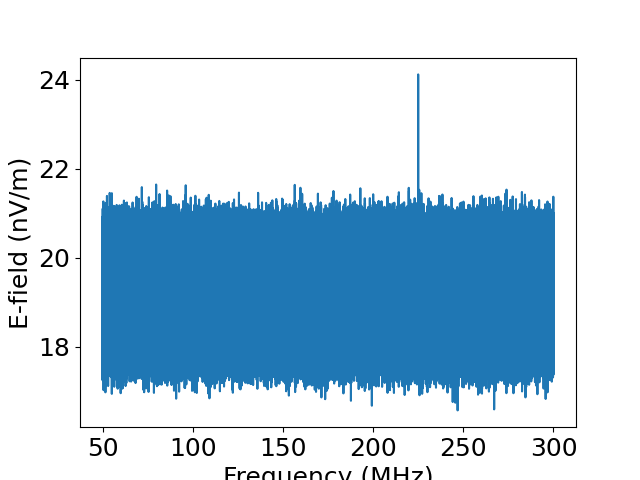

In [15]:
#overview plot 
#take mean and std from roach run 1 data. 
roachMeanPow = 1.5e-19 #W
roachStdPow = 1e-22 #W
print('################mean################')
P_lim = roachMeanPow
limCalc(P_lim)

print('################std################')
P_lim = roachStdPow
limCalc(P_lim)

#hard code values from above
roachMeanE = 1.9170289512680815e-08 #V/m
roachStdE = 4.949747468305833e-10 #V/m

E_data = np.random.normal(roachMeanE, roachStdE, size=2**23)

nSigmaLim = E_data.mean() + 5 * E_data.std() 

#set a bin high to fake signal
E_data[int(2**23 * .7)] = E_data.mean() + 10* E_data.std() 

freqs = np.linspace(50, 300, 2**23)

plt.close('all')
plt.figure()
plt.plot(freqs, E_data/1e-9)
#plt.plot((freqs.min(), freqs.max()),(nSigmaLim/1e-9, nSigmaLim/1e-9), 'r')
#plt.plot((freqs.min(), freqs.max()),(nSigmaLim/1e-9, nSigmaLim/1e-9), 'r')
plt.xlabel('Frequency (MHz)')
plt.ylabel('E-field (nV/m)')


In [ ]:
myData = genData(sigFreqs = [123.456],
                     sigAmps = [0.09],
                     mean = 127,
                     std = 30,
                     numSamples = 2**18,
                     sampleRate = 600,
                     numAvg = 500)


myData.computePowAvg()


In [ ]:
powMean = myData.powAvg.mean()
powStd = myData.powAvg.std()
thresh = powMean + (5 * powStd)
print(np.log10(thresh))


plt.close('all')

plt.style.use('dark_background')
#plt.style.use('classic')


plt.figure()
plt.plot(myData.freqs, (myData.powAvg)/2e9)
#plt.plot([0, 300],([thresh, thresh]), 'r--')
plt.xlabel('Freqency (MHz)', fontsize = 17)
plt.ylabel('E-Field (\u03BCV/m))', fontsize = 17)

'''
fig1 = plt.figure(1)
difference = np.abs(myData.powAvg)
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.plot(myData.freqs,difference, 'r', label = 'abs(comsol AF - cst AF)')
plt.legend()
plt.title('AF bicon in box (no res, galvanized steel, 1000 pts)')
plt.xlabel('Frequency [MHz]')
plt.ylabel('AF')
frame2=fig1.add_axes((.1,.1,.8,.2))        
plt.plot(myData.freqs, sps.zscore(myData.powAvg))
plt.plot([0, 300], [5,5])
#plt.plot(freq, af4, label = "comsol 20 log(mag(Ex/lpv)) + 5.6")
plt.legend()
'''

In [ ]:
freqs, power = np.load('./biconInRoom_1avg_0Gain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')


print('mean = ', power.mean(), 'dBm')
print('std = ', power.std(), 'dBm')

mean = power.mean()
std = power.std()


plt.close('all')
plt.figure()

plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room')
#plt.plot((30,300), (mean + 1*std, mean + 1*std))

print((power>(mean + std)).sum())


'''

plt.figure()
plt.hist(power, bins = 25);
plt.title('Bicon In Room')
'''


In [ ]:
freqsfull, powerfull = np.load('./biconInRoom_1avg_0Gain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')

freqszoom, powerzoom = np.load('./biconInRoom_1avg_0Gain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')


plt.close('all')
plt.figure()

plt.plot(freqsfull/1e6, powerfull, label = 'RBW = 30kHz')
plt.plot(freqszoom/1e6, powerzoom, alpha = .75, label = 'RBW = 100Hz')
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Bicon in Room')
plt.legend()

In [ ]:
freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs)

linMean = 10**((power - gain)/10).mean()
linMeandBm = 10*np.log10(linMean)
print("mean of output referred power = ", (power - gain).mean())
print("lin mean of output referred power = ", linMeandBm)

k = 1.38e-23
temp = 350
rbw = 100
pJohnsondBm = 10 * np.log10(k * temp * rbw * 1000)

print('theoritical Johnson noise for', temp, 'K', 100, 'Hz RBW = ', pJohnsondBm )

print('remember impedance match of antenna!!')

plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Input Referred Bicon in Room')

plt.figure()
plt.plot(freqs/1e6, gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Gain of Amp Chain')

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Output Referred Bicon in Room')


In [ ]:
freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW100Hz_100to101MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs, lengthMean = 5)




plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Input Referred Bicon in Room')

plt.figure()
plt.plot(freqs/1e6, gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Gain of Amp Chain')

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Output Referred Bicon in Room')

In [ ]:
#Amp chain gain for schamatic slide


measGain = dr.getExtGain()[1][1:]


plt.close('all')
plt.figure()
plt.plot(freqs[startFreqIdx:], measGain[startFreqIdx:], label = 'Measured gain + 20dB (ROACH internal)')
plt.title('Total Gain of Amp Chain')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain (dB)')


In [ ]:
#take 3 add gain

freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs, lengthMean = 5)

plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.xlim(50, 300)
plt.title('Input Referred Bicon in Room')

plt.figure()
plt.plot(freqs/1e6, gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.xlim(50, 300)
plt.title('Gain of Amp Chain')

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.xlim(50, 300)
plt.title('Output Referred Bicon in Room')

In [ ]:
#take 4 avg

freqs, power = np.load('./biconInRoom_1avg_56dBGain_10kpts_RBW30kHz_30to300MHz_preampOff_0Att.npy')
freqs, gain= dr.getExtGain(freqsInterp = freqs, lengthMean = 5)

plt.close('all')

plt.figure()
plt.plot(freqs/1e6, power - gain)
plt.xlabel('Freq. (MHz)')
plt.ylabel('Power (dBm)')
plt.title('Output Referred Bicon in Room')

In [3]:
freqs = np.load('../../daqAnalysisAndExperiments/run1Analysis/run1_freqData_avgAll11776Spectra_gitignore.npy')
antData = np.load('../../daqAnalysisAndExperiments/run1Analysis/run1_antData_avgAll11776Spectra_gitignore.npy')[1:]
termData = np.load('../../daqAnalysisAndExperiments/run1Analysis/run1_termData_avgAll11776Spectra_gitignore.npy')[1:]

1398101


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


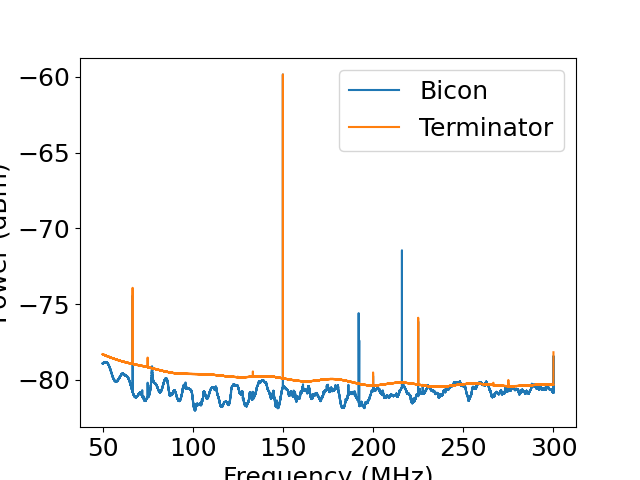

In [4]:
startFreq = 50 #Mhz
startFreqIdx = int(startFreq/300 * len(freqs))
print(startFreqIdx)

plt.close('all')
plt.figure()
plt.plot(freqs[startFreqIdx:], dr.fft2dBm(antData[startFreqIdx:]), label = 'Bicon')
plt.plot(freqs[startFreqIdx:], dr.fft2dBm(termData[startFreqIdx:]), label = 'Terminator')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
plt.legend(loc = 'upper right')

System temp =  375.0883694203085
total thermal background in dBm =  -157.32351661387784


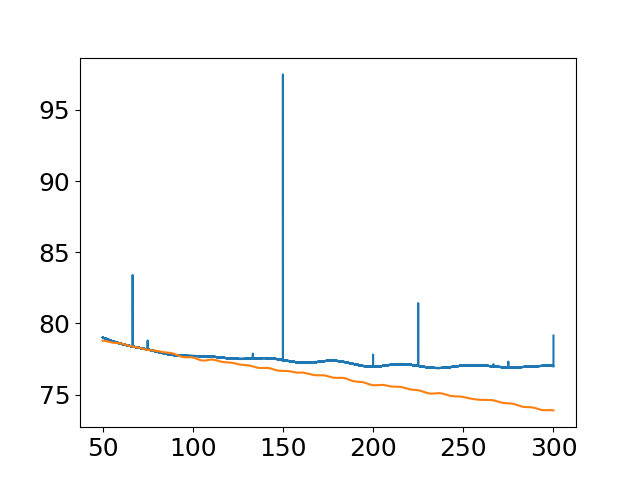

In [5]:
roomTemp = 300

NF = 1
ampTemp = 290  * (10**(NF/10) - 1)
sysTemp = ampTemp + roomTemp
print('System temp = ', sysTemp)

kb = 1.380649e-23 #J/K
deltaNu = (freqs[1] - freqs[0]) * 1e6 #Hz

thermalNoiseDens = kb * sysTemp 
thermalBg_dBm = 10*np.log10(thermalNoiseDens * deltaNu * 1000)
print('total thermal background in dBm = ', thermalBg_dBm)


selfGain = dr.fft2dBm(termData[startFreqIdx:]) - thermalBg_dBm 


measGain = dr.getExtGain()[1][1:]


plt.close('all')
plt.figure()
plt.plot(freqs[startFreqIdx:], selfGain, label = 'Gain assuming johnson + (NF = %f)' % round(NF, 1))
plt.plot(freqs[startFreqIdx:], measGain[startFreqIdx:] + 20.8, label = 'Measured gain + 20dB (ROACH internal)')
#plt.legend(loc = 'upper right')



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


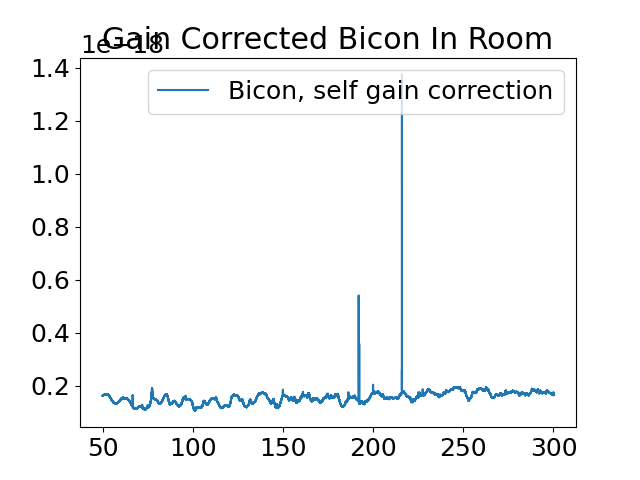

In [10]:
dataCorrecteddBm = dr.fft2dBm(antData[startFreqIdx:]) - selfGain
dataCorrectedLin = (10**(dataCorrecteddBm/10)) / 1000

plt.close('all')
plt.figure()
plt.plot(freqs[startFreqIdx:], dataCorrectedLin, label = 'Bicon, self gain correction')
#plt.plot(freqs[startFreqIdx:], dr.fft2dBm(antData[startFreqIdx:]) - measGain[startFreqIdx:] - 20.8 , label = 'Bicon, Measured gain correction')
plt.title('Gain Corrected Bicon In Room')
plt.legend(loc = 'upper right')

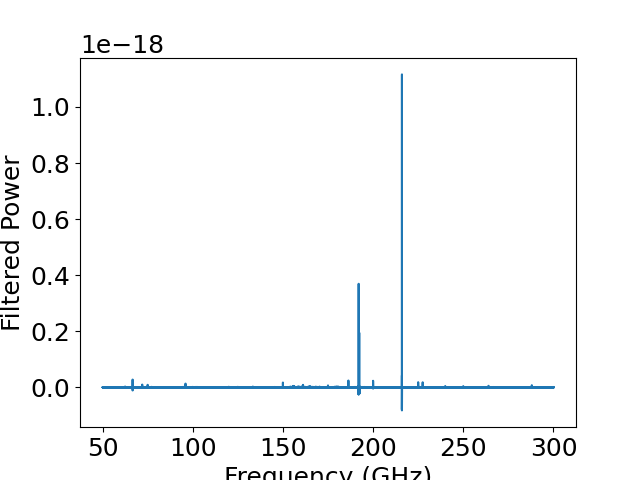

In [11]:
from scipy import signal

# Sampling rate such that the total amount of data is 1s
fs = len(antData)

# Cutoff in number of bins
fc = 30

# Normalize the frequency in term of Nyquist
fcNorm = 2./(fc)

# Create a 6th-order Butterworth filter - returns numerator (b) and denominator (a) polynomials of the IIR filter
b, a = signal.butter(6, fcNorm, 'highpass', analog = False)


# Apply the Butterworth filter to the acquired data that has been corrected for the 
# noise power of the amplifiers and the gain of the amplifiers
filteredData = signal.filtfilt(b, a, dataCorrectedLin[:])

plt.close('all')
plt.figure()
plt.plot((freqs[startFreqIdx:]), (filteredData))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Power')
plt.show()

In [ ]:
P_lim = 2e-20 #watts
P_lim = 10**(-173.73/10) / 1000 * 100
  
limCalc(P_lim)